<a href="https://colab.research.google.com/github/sun0809/BERT-project/blob/main/04_doc_cls_train_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 패키지 설치하기

TPU 관련 패키지를 설치합니다. TPU 사용시 아래 라인 첫 문자(#)를 지우고 수행하세요. GPU를 쓴다면 아래 라인을 실행할 필요가 없습니다.

In [ ]:
# TPU 사용시 아래 라인 첫 문자(#)를 지우고 수행하세요.
#!pip install cloud-tpu-client==0.10 https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.9-cp37-cp37m-linux_x86_64.whl

TPU 이외에 의존성 있는 패키지를 설치합니다.

In [2]:
!pip install ratsnlp

# 구글 드라이브 연동하기
코랩 노트북은 일정 시간 사용하지 않으면 당시까지의 모든 결과물이 날아갈 수 있습니다. 체크포인트 등을 저장해 둘 구글 드라이브를 연결합니다. 자신의 구글 계정에 적용됩니다.

In [3]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


# 각종 설정
이번 튜토리얼에서는 이준범 님이 공개하신 kcbert-base 모델을 NSMC 데이터로 파인튜닝해볼 예정입니다

모델 하이퍼파라메터(hyperparameter)와 저장 위치 등 설정 정보를 선언합니다.

In [4]:
import torch
from ratsnlp.nlpbook.classification import ClassificationTrainArguments
args = ClassificationTrainArguments(
    pretrained_model_name="beomi/kcbert-base",  #프리트레인 마친 언어모델의 이름
    downstream_corpus_name="nsmc", # 다운스트림 데이터의 이름
    downstream_model_dir="/gdrive/My Drive/nlpbook/checkpoint-doccls",  # 파인튜닝된 모델의 체크포인트가 저장될 위치. 
    batch_size=32 if torch.cuda.is_available() else 4, #TPU로 설정했다면 4
    learning_rate=5e-5,   
    max_seq_length=128,  # 패딩과 같은 의미 / 이보다 긴문장은 자르고 짧은 문장은 padding을 진행한다. 
    epochs=3,
    tpu_cores=0 if torch.cuda.is_available() else 8, # GPU면 TPU 코어수 0 TPU면 8
    seed=7,
)

# 랜덤 시드 고정

랜덤시드 
난수는 배치(batch)를 뽑거나 드롭아웃 대상 뉴런의 위치를 정할 때 등 다양하게 쓰입니다. 컴퓨터는 난수 생성 알고리즘을 사용해 난수를 만들어내는데요. 이 때 난수 생성 알고리즘을 실행하기 위해 쓰는 수를 랜덤 시드라고 합니다. 만일 같은 시드를 사용한다면 컴퓨터는 계속 같은 패턴의 난수를 생성하게 됩니다.

학습 재현을 위해 랜덤 시드를 고정합니다.

In [7]:
from ratsnlp import nlpbook
nlpbook.set_seed(args)

set seed: 7


# 로거 설정
메세지 출력 등을 위한 logger를 설정합니다.

In [9]:
nlpbook.set_logger(args)

INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/My Drive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_size=32, cpu_workers=2, fp16=False, tpu_cores=0)
INFO:ratsnlp:Training/evaluation parameters ClassificationTrainArguments(pretrained_model_name='beomi/kcbert-base', downstream_task_name='document-classification', downstream_corpus_name='nsmc', downstream_corpus_root_dir='/content/Korpora', downstream_model_dir='/gdrive/My Drive/nlpbook/checkpoint-doccls', max_seq_length=128, save_top_k=1, monitor='min val_loss', seed=7, overwrite_cache=False, force_download=False, test_mode=False, learning_rate=5e-05, epochs=3, batch_siz

# 말뭉치 다운로드
실습에 사용할 말뭉치(Naver Sentiment Movie review Corpus)를 다운로드합니다.

코드 4-7을 실행하면 NSMC 데이터 다운로드를 수행합니다. 데이터를 내려받는 도구로 코포라(Korpora)라는 오픈소스 파이썬 패키지를 사용해, corpus_name(nsmc)에 해당하는 말뭉치를 코랩 환경 로컬의 root_dir(/content/Korpora) 이하에 저장해 둡니다.

In [10]:
from Korpora import Korpora
Korpora.fetch(
    corpus_name=args.downstream_corpus_name,
    root_dir=args.downstream_corpus_root_dir,
    force_download=True,
)

[nsmc] download ratings_train.txt: 14.6MB [00:00, 85.6MB/s]                            
[nsmc] download ratings_test.txt: 4.90MB [00:00, 40.5MB/s]                            


# 토크나이저 준비
토큰화를 수행하는 토크나이저를 선언합니다

이준범 님이 공개하신 kcbert-base 모델이 사용하는 토크나이저(tokenizer)를 선언합니다. 토크나이저(tokenizer)는 토큰화를 수행하는 프로그램이라는 뜻입니다.

In [11]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    args.pretrained_model_name,
    do_lower_case=False,
)

Downloading:   0%|          | 0.00/250k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/619 [00:00<?, ?B/s]

# 학습데이터 구축
학습데이터를 만듭니다.

아래의 코드를 수행하면 그림 4-3의 데이터셋(Dataset)을 만들 수 있습니다. 코드 4-8에서 NsmcCorpus는 CSV 파일 형식의 NSMC 데이터를 “문장(영화 리뷰) + 레이블(긍정, 부정)” 형태로 읽어들이는 역할을 하고요. 
ClassificationDataset는 그림 4-3의 데이터셋 역할을 수행합니다.

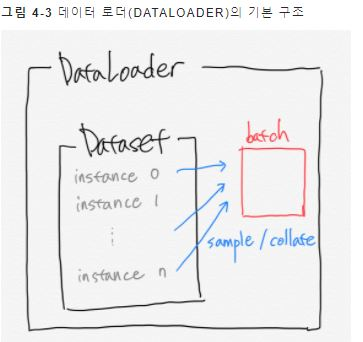

# tokenizer=tokenizer 살펴보기 
corpus로 들어온 데이터
*   text : 아 더빙...진짜 짜증나네요 목소리
*   label : 0(부정)

-> 
* input_ids : 텍스트를 인코딩 한 값 
* attention_mask : 해당 토큰이 패딩 토큰인지(0) 아닌지(1)
* token_type_ids :세그먼트(segment) 정보로 기본값은 모두 0으로 넣습니다.


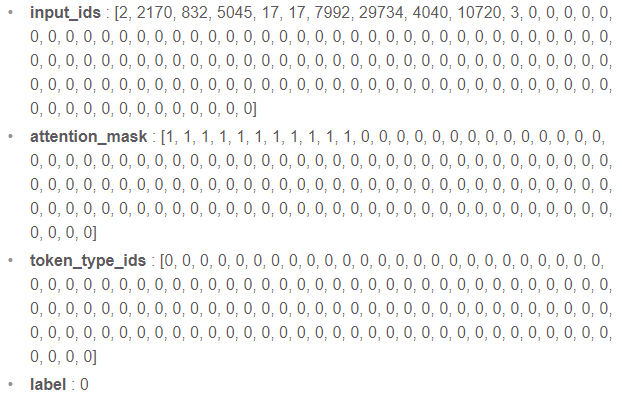

4개의 요소가 하나의 Instance를 구성


# nlpbook.data_collator 살펴보기 
리스트형의 인스턴스 ->   
#  
RandomSampler 를 사용하여 배치 사이즈만큼 추출 ->
#  
nlpbook.data_collator 를 사용하여 tensor 형으로 변환 
#  
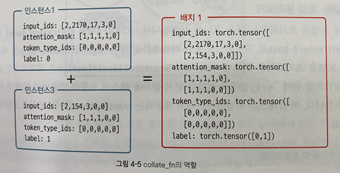

In [12]:
from torch.utils.data import DataLoader, SequentialSampler, RandomSampler
from ratsnlp.nlpbook.classification import NsmcCorpus, ClassificationDataset
corpus = NsmcCorpus()    #“문장(영화 리뷰) + 레이블(긍정, 부정)”

## 데이터 토크나이저 하기 : 모델이 학습할 수 있는 형태로 가공
train_dataset = ClassificationDataset(  
    args=args,
    corpus=corpus,#“문장(영화 리뷰) + 레이블(긍정, 부정)”
    tokenizer=tokenizer, #모델이 학습할 수 있는 형태로 가공
    mode="train",
)

# 전체 인스턴스 가운데 배치크기 만큼 뽑아 배치형태로 가공하기 
train_dataloader = DataLoader(
    train_dataset,
    batch_size=args.batch_size,
    sampler=RandomSampler(train_dataset, replacement=False), # 배치를 만들 대 전체 인스턴스 중 배치사이즈 수 만큼 비복원 추출을 한다. 
    collate_fn=nlpbook.data_collator, # 리스트 형의 ClassificationDataset를 tensor형으로 바꾼다. 
    drop_last=False,
    num_workers=args.cpu_workers,
)

INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:loading train data... LOOKING AT /content/Korpora/nsmc/ratings_train.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 47.257 s]
INFO:ratsnlp:tokenize sentences [took 47.257 s]
INFO:ratsnlp:tokenize sentences [took 47.257 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 아 더빙.. 진짜 짜증나네요 목소리
INFO:ratsnlp:sentence: 아 더빙.. 진짜 짜증나네요 목소리
INFO:ratsnl

# 테스트 데이터 구축
학습 중에 평가할 테스트 데이터를 구축합니다.

In [13]:
val_dataset = ClassificationDataset(
    args=args,
    corpus=corpus,
    tokenizer=tokenizer,
    mode="test",
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=args.batch_size,
    sampler=SequentialSampler(val_dataset), # 평가용 데이터 로더 구축. batch_size만큼의 갯수만큼을 인스턴스 순서대로 추출하는 역할을 합니다. #학습은 랜덤 평가는 순서대로
    collate_fn=nlpbook.data_collator,
    drop_last=False,
    num_workers=args.cpu_workers,
)


INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:Creating features from dataset file at /content/Korpora/nsmc
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:loading test data... LOOKING AT /content/Korpora/nsmc/ratings_test.txt
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences, it could take a lot of time...
INFO:ratsnlp:tokenize sentences [took 28.763 s]
INFO:ratsnlp:tokenize sentences [took 28.763 s]
INFO:ratsnlp:tokenize sentences [took 28.763 s]
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:*** Example ***
INFO:ratsnlp:sentence: 굳 ㅋ
INFO:ratsnlp:sentence: 굳 ㅋ
INFO:ratsnlp:sentence: 굳 ㅋ
INFO:ratsnlp:tokens: [

# 모델 초기화
프리트레인이 완료된 BERT 모델을 읽고, 문서 분류를 수행할 모델을 초기화합니다.


BertForSequenceClassification은 프리트레인을 마친 BERT 모델 위에 4-1장에서 설명한 문서 분류용 태스크 모듈이 덧붙여진 형태의 모델 클래스입니다. BertForSequenceClassification은 허깅페이스(huggingface)에서 제공하는 transformers 라이브러리에 포함돼 있습니다.

In [14]:
# 모델 초기화
from transformers import BertConfig, BertForSequenceClassification
pretrained_model_config = BertConfig.from_pretrained(
    args.pretrained_model_name,
    num_labels=corpus.num_labels,
)

In [15]:
model = BertForSequenceClassification.from_pretrained(
        args.pretrained_model_name,
        config=pretrained_model_config,
)

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at beomi/kcbert-base were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initiali

# 학습 준비
Task와 Trainer를 준비합니다.
아래 코드를 실행하면 문서 분류용 태스크를 정의할 수 있습니다. 
모델은 위에서 준비한 모델 클래스를 ClassificationTask에 포함시킵니다. 
클래스에는 옵티마이저, 러닝레이트 스케줄러(learning rate scheduler)가 정의되어 있는데요. 옵티마이저로는 아담(Adam), 러닝레이트 스케줄러로는 ExponentialLR을 사용합니다.

In [16]:
from ratsnlp.nlpbook.classification import ClassificationTask
task = ClassificationTask(model, args)

## 파이토치 라이트닝(pytorch lightning)이 제공하는 라이트닝 모듈(LightningModule) 클래스를 상속받아 태스크(task)를 정의합니다. 
## 태스크에는 모델과 옵티마이저(optimizer), 학습 과정(training process) 등이 정의돼 있습니다.

In [17]:
##트레이너 정리 
#트레이너는 파이토치 라이트닝 라이브러리의 도움을 받아 GPU/TPU 설정,
# 로그 및 체크포인트 등 귀찮은 설정들을 알아서 해줍니다.

trainer = nlpbook.get_trainer(args)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


# 학습
준비한 데이터와 모델로 학습을 시작합니다. 학습 결과물(체크포인트)은 미리 연동해둔 구글 드라이브의 준비된 위치(`/gdrive/My Drive/nlpbook/checkpoint-doccls`)에 저장됩니다.

In [ ]:
trainer.fit(
    task,
    train_dataloader=train_dataloader,
    val_dataloaders=val_dataloader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                          | Params
--------------------------------------------------------
0 | model | BertForSequenceClassification | 108 M 
--------------------------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
435.680   Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]